# Import

In [3]:
import numpy as np
import pandas as pd
from pycaret.datasets import get_data
from scipy.stats import chi2_contingency
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from catboost import CatBoostClassifier, Pool
import matplotlib.pyplot as plt
from tqdm import tqdm

# Utils

In [4]:
def get_dataset(dataset_name):
  """Get dataset."""
  target_name = dataset_name2target_name[dataset_name]
  df = get_data(dataset_name, verbose=False).dropna(subset=[target_name])
  X, y = df.drop(target_name, axis=1), df[target_name]
  num_features = X.columns[X.apply(is_numeric)].tolist()
  cat_features = [c for c in X.columns if c not in num_features]
  n_classes = len(set(y))
  X.loc[:, cat_features] = X.loc[:, cat_features].fillna("NULL")
  return X, y, num_features, cat_features, n_classes

def is_numeric(x):
  """Check whether an object is numeric."""
  try:
    x+0
    return True
  except:
    return False

def get_roc_auc_score(y_true, y_score):
  """Get area under ROC curve."""
  if y_score.shape[1] == 2:
    return roc_auc_score(y_true, np.array(y_score)[:, 1])
  else:
    return roc_auc_score(y_true, y_score, multi_class="ovr")
    
def get_y_proba(roc, n=100000, prevalence=.5):
  """Get two arrays, y and proba, for a given ROC (greater than .5)."""
  n_ones = int(round(n * prevalence))
  n_zeros = n - n_ones
  y = np.array([0] * n_zeros + [1] * n_ones)
  alpha = np.abs(roc - .5) * 2
  proba_zeros = np.linspace(0, 1, n_zeros)
  proba_ones = np.linspace(alpha, 1, n_ones)
  proba = np.concatenate([proba_zeros, proba_ones])
  return y, proba

def test_roc_difference(roc_1, roc_2, n, prevalence, alpha=.05):
  """Test whether the difference between the ROC score of two models on the same test set is significant."""  
  y_universe, proba_universe = get_y_proba(roc=min(roc_1, roc_2), n=100_000, prevalence=prevalence)
  rocs_obs = []
  i = 0
    
  while i < 100:
    try:
      index = np.random.choice(range(len(y_universe)), n, replace=True)
      y_sample, proba_sample = y_universe[index], proba_universe[index]
      rocs_obs.append(roc_auc_score(y_sample, proba_sample))
      i += 1
    except:
      pass
        
  if max(roc_1, roc_2) > np.quantile(rocs_obs, 1-alpha): 
    return True
  else: 
    return False

def make_strings_unique(strings, zfill=2):
  strings_count = [str(strings[:i].count(strings[i]) + 1) for i in range(len(strings))]
  strings_unique = [string + "_" + string_count.zfill(zfill) for string, string_count in zip(strings, strings_count)]
  return strings_unique

# Init

In [5]:
dataset_name2target_name = {
  "bank": "deposit",
  "blood": "Class",
  "cancer": "Class",
  "credit": "default",
  "diabetes": "Class variable",
  "electrical_grid": "stabf",
  "employee": "left",
  "heart": "DEATH",
  "heart_disease": "Disease",
  "hepatitis": "Class",
  "income": "income >50K",
  "juice": "Purchase",
  "nba": "TARGET_5Yrs",
  "wine": "type",
  "telescope": "Class",
  "titanic": "Survived",
  "us_presidential_election_results": "party_winner",
  "glass": "Type",
  "iris": "species",
  "poker": "CLASS",
  "questions": "Next_Question",
  "satellite": "Class",
  "CTG": "NSP"
}

# Show summary of datasets

In [6]:
dataset_names = list(dataset_name2target_name.keys())
dataset_summary = pd.DataFrame(columns=["dataset", "rows", "cols", "null_perc", "classes"])

for dataset_name in dataset_names:
            
  X, y, num_features, cat_features, n_classes = get_dataset(dataset_name)
    
  dataset_summary = dataset_summary.append(pd.Series(
    data=[dataset_name, X.shape[0], X.shape[1], X.isna().mean().mean(), len(set(y))],
    index=dataset_summary.columns
  ),ignore_index=True)

dataset_summary

,dataset,rows,cols,null_perc,classes
0,bank,45211,16,0.000000,2
1,blood,748,4,0.000000,2
2,cancer,683,9,0.000000,2
3,credit,24000,23,0.000000,2
4,diabetes,768,8,0.000000,2
5,electrical_grid,10000,12,0.000000,2
6,employee,14999,9,0.000000,2
7,heart,200,15,0.000000,2
8,heart_disease,270,13,0.000000,2
9,hepatitis,154,19,0.052290,2


# Build a single dataset out of totally unrelated datasets

In [7]:
dataset_names = dataset_summary.loc[(dataset_summary["rows"] >= 5000) & (dataset_summary["classes"] == 2), "dataset"].tolist()

dataset_summary.loc[dataset_summary.dataset.isin(dataset_names), ["dataset", "rows", "cols"]].reset_index(drop=True)

,dataset,rows,cols
0,bank,45211,16
1,credit,24000,23
2,electrical_grid,10000,12
3,employee,14999,9
4,income,32561,13
5,wine,6497,12
6,telescope,19020,10


In [8]:
dataset_names = dataset_summary.loc[(dataset_summary["rows"] >= 5000) & (dataset_summary["classes"] == 2), "dataset"].tolist()

X_list, y_list, feature_map, replace_map, target_map = [], [], {}, {}, {}

for dataset_name in tqdm(dataset_names):
  X, y, num_features, cat_features, n_classes = get_dataset(dataset_name)

  target_map[dataset_name] = dict(zip(y.value_counts().index, [0,1]))

  replace_map[dataset_name] = {}
  for cat_feature in cat_features:
    unique_values = X[cat_feature].value_counts().index
    replace_map[dataset_name][cat_feature] = dict(zip(unique_values, [str(i) for i in range(len(unique_values))]))
  
  model = CatBoostClassifier().fit(X=X, y=y.replace(target_map[dataset_name]), cat_features=cat_features, silent=True)
  original_feature_names = pd.Series(model.feature_importances_, index=model.feature_names_).sort_values(ascending=False).index
  new_feature_names = make_strings_unique(["num_feature" if feat in num_features else "cat_feature" for feat in original_feature_names])
  feature_map[dataset_name] = dict(zip(original_feature_names, new_feature_names))

  # standardize each numerical column
  # map each value of each categorical column into a distinct integer,
  # add a column containing the name of the dataset
  # rename columns as cat_feature_01, cat_feature_02, ..., num_feature_01, num_feature_02, ...
  X.loc[:, num_features] = X.loc[:, num_features].apply(lambda col: (col - col.mean()) / col.std())
  X = X.replace(replace_map[dataset_name]).assign(dataset = dataset_name).rename(feature_map[dataset_name], axis=1)

  # map each value of y into 0 or 1
  y = y.replace(target_map[dataset_name]).rename("target")
  
  X_list.append(X)
  y_list.append(y)
    
X = pd.concat(X_list).reset_index(drop=True)
y = pd.concat(y_list).reset_index(drop=True)

cat_features = X.columns[(X.columns == "dataset") | (X.columns.str.startswith("cat_"))].to_list()
num_features = X.columns[X.columns.str.startswith("num_")].to_list()

X = X.loc[:, ["dataset"] + sorted(X.drop("dataset", axis=1).columns)]
X.loc[:, cat_features] = X.loc[:, cat_features].fillna("NULL")

100%|██████████| 7/7 [02:19<00:00, 19.88s/it]


In [9]:
print("original shape:", (sum([len(X_) for X_ in X_list]), sum([len(X_.columns) for X_ in X_list])))
print("shape:", X.shape)

original shape: (152288, 102)
shape: (152288, 33)


# Run experiments

In [10]:
%%time

results = pd.DataFrame(columns=["dataset", "count", "distr", "roc_general", "roc_specialized"])
models_specialized = {}
preds_specialized = pd.DataFrame()

ix_train, ix_test = train_test_split(X.index, test_size=.25, stratify=y.astype(str) + " " + X["dataset"])
model_general = CatBoostClassifier().fit(X=X.loc[ix_train,:], y=y.loc[ix_train], cat_features=cat_features, silent=True)
pred_general = pd.DataFrame(model_general.predict_proba(X.loc[ix_test, :]), index=ix_test, columns=model_general.classes_)
    
for dataset_name in tqdm(X["dataset"].unique()):
      
  # split index in training and test set, then train specialized model 
  # on the portion of the training set that belongs to the segment
  ix_value = X.loc[X.loc[:, "dataset"] == dataset_name, :].index   
  ix_train_specialized = list(set(ix_value).intersection(ix_train))
  ix_test_specialized = list(set(ix_value).intersection(ix_test))

  model_specialized = CatBoostClassifier().fit(X=X.loc[ix_train_specialized,:], y=y.loc[ix_train_specialized], cat_features=cat_features, silent=True)
  models_specialized[dataset_name] = model_specialized
  pred_specialized = pd.DataFrame(model_specialized.predict_proba(X.loc[ix_test_specialized, :]), index=ix_test_specialized, columns=model_specialized.classes_)
  preds_specialized = pd.concat([preds_specialized, pred_specialized])

  # compute roc score of both the general model and the specialized model and save them
  roc_auc_score_general = get_roc_auc_score(y.loc[ix_test_specialized], pred_general.loc[ix_test_specialized, :])
  roc_auc_score_specialized = get_roc_auc_score(y.loc[ix_test_specialized], pred_specialized)  
  results = results.append(pd.Series(data=[dataset_name, len(ix_test_specialized), y.loc[ix_test_specialized].value_counts().to_list(), roc_auc_score_general, roc_auc_score_specialized], index=results.columns),ignore_index=True)

100%|██████████| 7/7 [01:59<00:00, 17.13s/it]

CPU times: user 20min 11s, sys: 45.8 s, total: 20min 57s
Wall time: 5min 31s


In [11]:
pred_general.corrwith(preds_specialized)[1]

0.9789673843332688

In [12]:
(results.loc[:, "roc_specialized"] - results.loc[:, "roc_general"]).sort_values()

1   -0.002396
5    0.002032
0    0.003908
4    0.006699
3    0.007735
2    0.008342
6    0.011142
dtype: float64

In [13]:
(results.loc[:, "roc_specialized"] - results.loc[:, "roc_general"]).mean()

0.00535186365458616

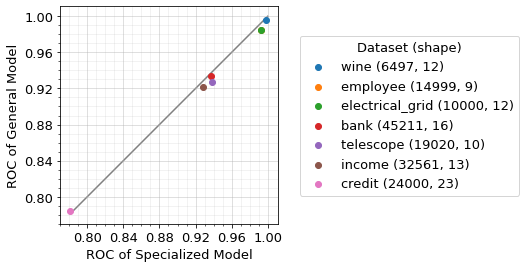

In [28]:
fig, ax = plt.subplots()

ax.plot([results.loc[:,["roc_specialized", "roc_general"]].min().min(),1],[results.loc[:,["roc_specialized", "roc_general"]].min().min(),1], color="grey", zorder=0)

for dataset in results.sort_values("roc_general", ascending=False).loc[:, "dataset"]:
  rows, cols = dataset_summary.loc[dataset_summary["dataset"] == dataset, ["rows", "cols"]].iloc[0,:]
  ax.scatter(
    results.loc[results["dataset"]==dataset,"roc_specialized"], 
    results.loc[results["dataset"]==dataset,"roc_general"], 
    label=f"{dataset} ({rows}, {cols})",
    zorder=2
  )

major_ticks = np.linspace(.8, 1., 6)
minor_ticks = np.linspace(.77, 1., 24)

ax.set_xticks(major_ticks)
ax.set_xticks(minor_ticks, minor=True)
ax.set_yticks(major_ticks)
ax.set_yticks(minor_ticks, minor=True)

ax.grid(which='both', zorder=1)
ax.grid(which='minor', alpha=0.2)
ax.grid(which='major', alpha=0.5)

ax.set_ylabel("ROC of General Model", fontsize=13)
ax.set_xlabel("ROC of Specialized Model", fontsize=13)
ax.tick_params(axis="both", which="major", labelsize=13)
ax.set_aspect("equal", "box")

legend = fig.legend(loc="center left", bbox_to_anchor=(.8, .5), fontsize=13)
legend.set_title("Dataset (shape)",prop={'size': 13})

fig.savefig("roc_compared.png", dpi=200, bbox_inches="tight")

In [15]:
corr_shap_specialized = pd.DataFrame(index=sorted(X.loc[ix_test, "dataset"].unique()), columns=num_features)

for dataset in models_specialized.keys():

  ix_value = X.loc[X.loc[:, "dataset"] == dataset_name, :].index   
  #ix_train_specialized = list(set(ix_value).intersection(ix_train))
  ix_test_specialized = list(set(ix_value).intersection(ix_test))  
  
  shap_test = pd.DataFrame(
    models_specialized[dataset].get_feature_importance(data = Pool(X.loc[ix_test_specialized, :], cat_features=cat_features), type = 'ShapValues')[:,:-1],
    columns = X.columns,
    index = ix_test_specialized)

  corr_shap_specialized.loc[dataset, :] = shap_test[num_features].corrwith(X.loc[:, num_features])

In [16]:
shap_test = pd.DataFrame(
  model_general.get_feature_importance(data = Pool(X.loc[ix_test, :], cat_features=cat_features), type = 'ShapValues')[:,:-1],
  columns = X.columns,
  index = ix_test
)

corr_shap_general = shap_test[num_features].groupby(X.loc[ix_test, "dataset"]).apply(lambda s: s.corrwith(X.loc[:, num_features]))
corr_shap_general = corr_shap_general.loc[:, sorted(corr_shap_general.columns)]

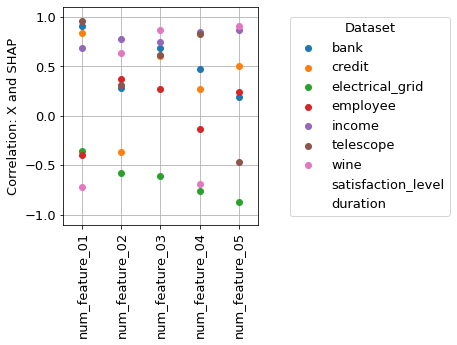

In [17]:
fig, ax = plt.subplots(figsize=(3.5,4))

for dataset in corr_shap_general.index:
  cols = corr_shap_general.columns[:5]
  ax.scatter(cols, corr_shap_general.loc[dataset, cols], label=dataset)
    
ax.scatter(.5, .25, label="satisfaction_level", color="white")
ax.scatter(.5, .25, label="duration", color="white")
  
ax.tick_params(axis='x', rotation=90)

ax.set_ylabel("Correlation: X and SHAP", fontsize=13)
ax.tick_params(axis="both", which="major", labelsize=13)
ax.set_xlim(-.5, 4.5)
ax.set_ylim(-1.1,1.1)

legend = fig.legend(loc="center left", bbox_to_anchor=(1, .5), fontsize=13)
legend.set_title("Dataset",prop={'size': 13})

ax.set_axisbelow(True)
ax.grid()

fig.savefig("corr_shap_X.png", dpi=200, bbox_inches="tight")

In [30]:
[(dataset, [old_col for old_col, new_col in fmap.items() if new_col == 'num_feature_01'][0]) for dataset, fmap in feature_map.items()]

[('bank', 'duration'),
 ('credit', 'PAY_1'),
 ('electrical_grid', 'tau4'),
 ('employee', 'satisfaction_level'),
 ('income', 'capital-gain'),
 ('wine', 'total sulfur dioxide'),
 ('telescope', 'fAlpha')]